# Face Image Classification (Practicing the Babysitting Method for training the Neural Networks) 

In [2]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow_datasets as tfds
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
import matplotlib.pyplot as plt
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

Using TensorFlow backend.


Num GPUs Available:  1


The results are produced on a GTX 1660 Ti GPU

# Data Reading


In [3]:
os.chdir(r'C:\1_WorkSpace\Professional\NC_States\2nd_Sem_Spring_2020\ECE_763_Computer_Vision\Projects\Project_03')
DataPath = 'Data\\'
df = pd.read_csv(DataPath +'Final_Data_Set.csv')

print('Number of Non-Faces: {}'.format(df.loc[df['IsFace']==0].shape))
print('Number of Faces: {}'.format(df.loc[df['IsFace']==1].shape))
df.head()

Number of Non-Faces: (1021, 2)
Number of Faces: (1616, 2)


,Image,IsFace
0,annotated_data\face\image0.jpg,1.0
1,annotated_data\face\image10.jpg,1.0
2,annotated_data\face\image100.jpg,1.0
3,annotated_data\face\image1000.jpg,1.0
4,annotated_data\face\image1001.jpg,1.0


The Image Database used for this project is a subset of the Face Detection and Data Set Benchmark (FDDB) http://vis-www.cs.umass.edu/fddb/. The Database consists of RGB images with annotations for the face bounding boxes. I extracted 1616 images from the dataset through careful filtering to avoid anomalies such as spectacles. The annotations provided in the form of rectangular coordinates are used for the extraction of the face boundary from the images. The non-face image data set is created using the same extracted images by carefully cropping the background while ensuring no or minimal overlap exists between the annotated face and background section(To learn more about the working of this open the data section and then open the dataprep.py)A sampling of the dataset is depicted below. 

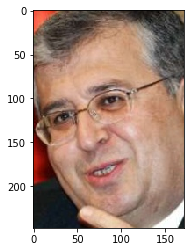

In [4]:
imageName =df.loc[df['IsFace']==1].at[0,'Image']
#print(imageName)
#print(DataPat+imageName)
image = cv2.imread(DataPath + imageName)
img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

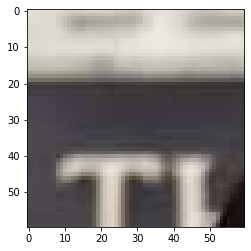

In [5]:
imageName =df.loc[df['IsFace']==0].at[1716,'Image']
#print(imageName)
#print(DataPat+imageName)
image = cv2.imread(DataPath + imageName)
img = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# Balancing the data with oversampling

As you can see the data is not proparly balanced in the above cases, there are plenty of methods for balancing an unbalanced data sets, the simplest of which is oversampling. Oversampling means sampling more data from the less represented classes.

In [6]:
df_new = df.loc[df['IsFace']==0]
df_new_final = df_new[0:595]
df = pd.concat([df,df_new_final])


In [7]:
print('Number of Non-Faces: {}'.format(df.loc[df['IsFace']==0].shape))
print('Number of Faces: {}'.format(df.loc[df['IsFace']==1].shape))
df = df.sample(frac=1).reset_index(drop=True)
df.head()

Number of Non-Faces: (1616, 2)
Number of Faces: (1616, 2)


,Image,IsFace
0,annotated_data\face\image1524.jpg,1.0
1,annotated_data\Non_face\image296.jpg,0.0
2,annotated_data\face\image1531.jpg,1.0
3,annotated_data\face\image439.jpg,1.0
4,annotated_data\face\image1546.jpg,1.0


# Creating Train-Test Split

The above dataset is divided into 85-15 train-test split

In [8]:

from sklearn.model_selection import train_test_split
dfTrain, dfTest = train_test_split(df, test_size=0.15)

print("Total Shape: {}".format(df.shape))
print("Train Shape: {}".format(dfTrain.shape))
print("Test Shape: {}".format(dfTest.shape))

print('Number of Training Non-Faces: {}'.format(dfTrain.loc[dfTrain['IsFace']==0].shape))
print('Number of Training Faces: {}'.format(dfTrain.loc[dfTrain['IsFace']==1].shape))

print('Number of Testing Non-Faces: {}'.format(dfTest.loc[dfTest['IsFace']==0].shape))
print('Number of Testing Faces: {}'.format(dfTest.loc[dfTest['IsFace']==1].shape))


Total Shape: (3232, 2)
Train Shape: (2747, 2)
Test Shape: (485, 2)
Number of Training Non-Faces: (1370, 2)
Number of Training Faces: (1377, 2)
Number of Testing Non-Faces: (246, 2)
Number of Testing Faces: (239, 2)


# Function for creating trainable data

After loading the dataset in the dataframe format it is important to create a X_Train, X_Test(numpy array of images), Y_Train, Y_Test(numpy array of labels) as the fit method in tensorflow requires the data to be either a tensor or a numpy array.  Here after reading the image the hist_equal() function applies histogram equalization to the image before tenorizing it. Histogram equalization removes any issues with under and or over exposer.

In [9]:
#Function for Histogram equalization

def hist_equal(img, flag = False):
    '''takes image and an output space [0,L] as an input and gives an equalized image(in float) as output'''
    if flag:
        img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if len(img.shape) != 2:
        R, G, B = cv2.split(img)
        output1_R = cv2.equalizeHist(R)
        output1_G = cv2.equalizeHist(G)
        output1_B = cv2.equalizeHist(B)
        equ = cv2.merge((output1_R, output1_G, output1_B))
        return equ
    return cv2.equalizeHist(img)


In [10]:

def df_to_processabledata(df_R,DataPath_R,flag=False):
    imagelist = []
    labellist = []
    for i in df_R.index:
        imageName = df_R.at[i,'Image']
        #print(imageName)
        #print(DataPath_R+imageName)
        image = cv2.imread(DataPath_R + imageName)
        
        #print(image.shape)
        image = hist_equal(image)
        image =cv2.resize(image,(60,60),interpolation = cv2.INTER_AREA)
        image = (image.astype(np.float))/255
        if (flag == True):
            image = image.flatten()
        label = df_R.at[i,'IsFace']
        
        labellist.append(label)
        imagelist.append(image)
        
    return np.asarray(imagelist) , np.asarray(labellist)
        
        

In [11]:
print(os.getcwd())
X_Train , Y_Train = df_to_processabledata(dfTrain,DataPath)
X_Test, Y_Test = df_to_processabledata(dfTest,DataPath)
print(X_Train.shape)
print(Y_Train.shape)




C:\1_WorkSpace\Professional\NC_States\2nd_Sem_Spring_2020\ECE_763_Computer_Vision\Projects\Project_03
(2747, 60, 60, 3)
(2747,)


# Data Preprocessing (Normalization)

Machine learining models work better with a normalized datasets.[]

In [12]:
mean = np.mean(X_Train, axis = 0)
stddev = np.std(X_Train, axis = 0)
print('Data Preprocessing')

Data Preprocessing


In [13]:
X_Train -= mean
X_Train /= stddev
X_Test -= mean
X_Test /=stddev


# Babysitting with a small and less complex structure

In [22]:
def model_creator(lr = '0.01',reg = '0',epoch = 5):
    model = tf.keras.Sequential()
    model.add(layers.Flatten(input_shape=(60,60,3)))
    model.add(layers.Dense(50,activation='elu',kernel_initializer='random_uniform',
                    bias_initializer='zeros',activity_regularizer=tf.keras.regularizers.l1(reg)))
    model.add(layers.Dropout(rate = 0.5))
    model.add(layers.Dense(2,activation = 'softmax'))

    sgd = tf.keras.optimizers.SGD(lr=lr, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(loss="sparse_categorical_crossentropy", optimizer=sgd, metrics=['accuracy'])
    history = model.fit(X_Train,Y_Train,batch_size=5, epochs=epoch, verbose=2, validation_split = 0.15)
    return model,history


In [23]:
lr = [0.1,0.01,0.001]
reg = [0,0.1,0.01,0.001]
for i in range(len(lr)):
    print("Learning Rate: {}".format(lr[i]))
    for j in range(len(reg)):
        print("Regilarization: {}".format(reg[j]))
        model_creator(lr[i],reg[j])
        

Learning Rate: 0.1
Regilarization: 0
Train on 2334 samples, validate on 413 samples
Epoch 1/5
2334/2334 - 2s - loss: nan - accuracy: 0.5103 - val_loss: nan - val_accuracy: 0.4746
Epoch 2/5
2334/2334 - 2s - loss: nan - accuracy: 0.5030 - val_loss: nan - val_accuracy: 0.4746
Epoch 3/5
2334/2334 - 2s - loss: nan - accuracy: 0.5030 - val_loss: nan - val_accuracy: 0.4746
Epoch 4/5
2334/2334 - 2s - loss: nan - accuracy: 0.5030 - val_loss: nan - val_accuracy: 0.4746
Epoch 5/5
2334/2334 - 2s - loss: nan - accuracy: 0.5030 - val_loss: nan - val_accuracy: 0.4746
Regilarization: 0.1
Train on 2334 samples, validate on 413 samples
Epoch 1/5
2334/2334 - 2s - loss: nan - accuracy: 0.5081 - val_loss: nan - val_accuracy: 0.4746
Epoch 2/5
2334/2334 - 2s - loss: nan - accuracy: 0.5030 - val_loss: nan - val_accuracy: 0.4746
Epoch 3/5
2334/2334 - 1s - loss: nan - accuracy: 0.5030 - val_loss: nan - val_accuracy: 0.4746
Epoch 4/5
2334/2334 - 2s - loss: nan - accuracy: 0.5030 - val_loss: nan - val_accuracy: 0

As it can be seen from above that learning rate of 0.001 and regularization of 0 is giving the best performannce, hence evaluating the model on those parameters.

In [25]:
model,history = model_creator(lr = 0.001,reg = 0, epoch=20)

Train on 2334 samples, validate on 413 samples
Epoch 1/20
2334/2334 - 1s - loss: 0.4326 - accuracy: 0.8967 - val_loss: 0.1479 - val_accuracy: 0.9492
Epoch 2/20
2334/2334 - 1s - loss: 0.1101 - accuracy: 0.9619 - val_loss: 0.1073 - val_accuracy: 0.9685
Epoch 3/20
2334/2334 - 1s - loss: 0.0887 - accuracy: 0.9674 - val_loss: 0.1416 - val_accuracy: 0.9637
Epoch 4/20
2334/2334 - 1s - loss: 0.0837 - accuracy: 0.9722 - val_loss: 0.1083 - val_accuracy: 0.9588
Epoch 5/20
2334/2334 - 1s - loss: 0.0507 - accuracy: 0.9803 - val_loss: 0.0977 - val_accuracy: 0.9758
Epoch 6/20
2334/2334 - 1s - loss: 0.0406 - accuracy: 0.9833 - val_loss: 0.0879 - val_accuracy: 0.9782
Epoch 7/20
2334/2334 - 1s - loss: 0.0422 - accuracy: 0.9871 - val_loss: 0.0868 - val_accuracy: 0.9806
Epoch 8/20
2334/2334 - 1s - loss: 0.0243 - accuracy: 0.9910 - val_loss: 0.0876 - val_accuracy: 0.9734
Epoch 9/20
2334/2334 - 1s - loss: 0.0287 - accuracy: 0.9927 - val_loss: 0.0812 - val_accuracy: 0.9831
Epoch 10/20
2334/2334 - 1s - loss: 

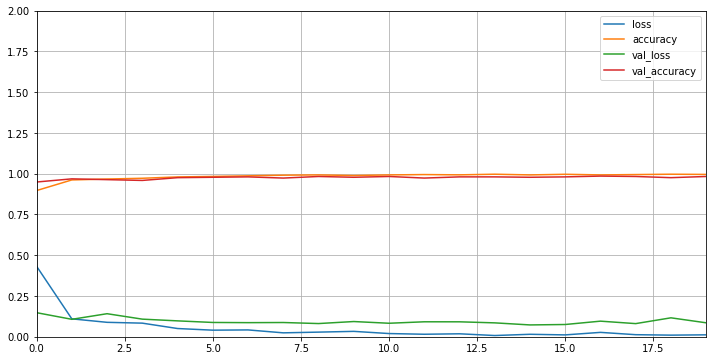

In [26]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

As it can be clearly seen that the model reaches optimum performance with almost 98% accuracy.

# Babysitting with ResNet50

In [27]:
IMAGE_SIZE = 60
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)
res_net = tf.keras.applications.ResNet50(weights=None, include_top=False, input_shape=IMG_SHAPE)


In [28]:
res_net.trainable = True

# Network Design (ResNet50 as a featureExtractor + Classifier)


Here I am using ResNet50 as a feature Extractor for my Network, I am randomly loading the weights []. After that I am adding a global average pooling layer and a fully connected softmax layer for output.

In [29]:
def ResModelCreator(lr=0.001,epoch = 5):
    global_average_layer = layers.GlobalAveragePooling2D()

    output_layer = layers.Dense(2, activation='softmax')

    tl_model = tf.keras.Sequential([
        res_net,
        global_average_layer,
        layers.BatchNormalization(),
        output_layer
    ])

    tf.keras.optimizers.Adam(
        learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
        name='Adam')
    #tl_model.summary()
    tl_model.compile(loss="sparse_categorical_crossentropy", optimizer='Adam', metrics=['accuracy'])
    history = tl_model.fit(X_Train,Y_Train,batch_size=25, epochs=epoch, verbose=2, validation_split = 0.15)
    return tl_model,history

In [30]:
lr = [0.1,0.01,0.001,0.0001]
for i in lr:
    ResModelCreator(lr = i)

Train on 2334 samples, validate on 413 samples
Epoch 1/5
2334/2334 - 15s - loss: 0.3723 - accuracy: 0.8809 - val_loss: 1.3146 - val_accuracy: 0.5254
Epoch 2/5
2334/2334 - 5s - loss: 0.0768 - accuracy: 0.9769 - val_loss: 1.1072 - val_accuracy: 0.5375
Epoch 3/5
2334/2334 - 5s - loss: 0.0585 - accuracy: 0.9807 - val_loss: 0.3367 - val_accuracy: 0.8450
Epoch 4/5
2334/2334 - 5s - loss: 0.0525 - accuracy: 0.9846 - val_loss: 0.2408 - val_accuracy: 0.9346
Epoch 5/5
2334/2334 - 5s - loss: 0.0895 - accuracy: 0.9764 - val_loss: 1.5612 - val_accuracy: 0.9274
Train on 2334 samples, validate on 413 samples
Epoch 1/5
2334/2334 - 10s - loss: 0.1899 - accuracy: 0.9422 - val_loss: 163.8880 - val_accuracy: 0.5061
Epoch 2/5
2334/2334 - 5s - loss: 0.0772 - accuracy: 0.9717 - val_loss: 4.4391 - val_accuracy: 0.8886
Epoch 3/5
2334/2334 - 5s - loss: 0.0705 - accuracy: 0.9764 - val_loss: 13.9681 - val_accuracy: 0.6973
Epoch 4/5
2334/2334 - 5s - loss: 0.1706 - accuracy: 0.9512 - val_loss: 1616.4837 - val_accura

As it can be seen that the best performance is obtained at 0.0001 learning rate, training the model for the same and comparing the results

# Training the Network

In [32]:
tl_model,tl_history = ResModelCreator(lr = 0.0001,epoch =5)

Train on 2334 samples, validate on 413 samples
Epoch 1/5
2334/2334 - 10s - loss: 0.0493 - accuracy: 0.9747 - val_loss: 0.0481 - val_accuracy: 0.9855
Epoch 2/5
2334/2334 - 5s - loss: 0.0117 - accuracy: 0.9966 - val_loss: 13.4215 - val_accuracy: 0.8935
Epoch 3/5
2334/2334 - 5s - loss: 0.0229 - accuracy: 0.9936 - val_loss: 0.0072 - val_accuracy: 0.9976
Epoch 4/5
2334/2334 - 5s - loss: 0.1773 - accuracy: 0.9893 - val_loss: 0.0832 - val_accuracy: 0.9903
Epoch 5/5
2334/2334 - 5s - loss: 0.0202 - accuracy: 0.9931 - val_loss: 0.0090 - val_accuracy: 0.9952


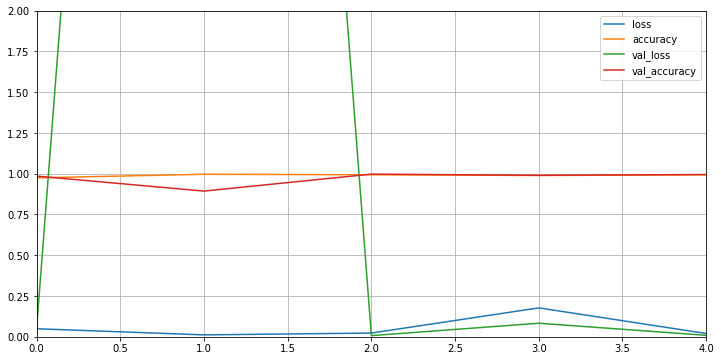

In [33]:
import matplotlib.pyplot as plt
pd.DataFrame(tl_history.history).plot(figsize=(12, 6))
plt.grid(True)
plt.gca().set_ylim(0,2)
plt.show()

As it can be seen that the optimum performance is obtained with 98% accuracy on the validation set

# Prediction

In [35]:

prediction_results = tl_model.predict(X_Test)
prediction_results_simpleNN = model.predict(X_Test)


In [36]:
prediction_results.shape
prediction_result = np.argmax(prediction_results,axis =1)
prediction_result_simpleNN = np.argmax(prediction_results_simpleNN,axis=1) 

# Prediction Analysis of Simple NN 

In [37]:
from sklearn.metrics import f1_score, precision_score,recall_score,accuracy_score
print("F1 Scores")
print(f1_score(Y_Test,prediction_result_simpleNN, average = None))
print("Precision Scores")
print(precision_score(Y_Test,prediction_result_simpleNN, average = None))
print("Recall")
print(recall_score(Y_Test,prediction_result_simpleNN, average = None))
print("Accuracy")
print(accuracy_score(Y_Test,prediction_result_simpleNN))

F1 Scores
[0.97804391 0.97654584]
Precision Scores
[0.96078431 0.99565217]
Recall
[0.99593496 0.958159  ]
Accuracy
0.977319587628866


# Prediction analysis of ResNet based architecture

In [38]:
from sklearn.metrics import f1_score, precision_score,recall_score,accuracy_score
print("F1 Scores")
print(f1_score(Y_Test,prediction_result, average = None))
print("Precision Scores")
print(precision_score(Y_Test,prediction_result, average = None))
print("Recall")
print(recall_score(Y_Test,prediction_result, average = None))
print("Accuracy")
print(accuracy_score(Y_Test,prediction_result))

F1 Scores
[0.9979716  0.99790356]
Precision Scores
[0.99595142 1.        ]
Recall
[1.        0.9958159]
Accuracy
0.9979381443298969


To conclude on a large enough data sets it can be said that we can achieve better performance with convNets but on a relatively smaller datasets which are properly seprable a classical fully connected network can also achieve optimum performance.